## Imports and model initialization

In [8]:
# !pip install kipoi
# !pip install kipoiseq
# !pip install pybedtools
# !pip uninstall -y kipoi_veff
# !pip install git+https://github.com/an1lam/kipoi-veff
# !pip install pyvcf
import csv
import math
import pickle

import kipoi
from kipoi_interpret.importance_scores.ism import Mutation
from kipoiseq.dataloaders import SeqIntervalDl
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

In [9]:
!pwd

/home/stephenmalina/project/src


# Loading DNA sequence data

In [10]:
dl = SeqIntervalDl("../dat/50_random_seqs_2.bed", "../dat/hg19.fa", auto_resize_len=1000)
data = dl.load_all()

100%|██████████| 2/2 [00:00<00:00, 38.77it/s]


In [11]:
seqs = np.expand_dims(data['inputs'].transpose(0, 2, 1), 2).astype(np.float32)
seqs.shape

(50, 4, 1, 1000)

# Loading DeepSEA

In [12]:
import tensorflow as tf
print("TF version:", tf.__version__)
import torch
print("torch version:", torch.__version__)
from torch import nn

TF version: 1.14.0
torch version: 1.3.1


In [13]:
# df = kipoi.list_models()
# deepsea_models = df[df.model.str.contains("DeepSEA")]
# deepsea_models.head()

In [14]:
deepsea = kipoi.get_model("DeepSEA/predict", source="kipoi")
deepsea.model

Using downloaded and verified file: /home/stephenmalina/.kipoi/models/DeepSEA/predict/downloaded/model_files/weights/89e640bf6bdbe1ff165f484d9796efc7


Sequential(
  (0): ReCodeAlphabet()
  (1): ConcatenateRC()
  (2): Sequential(
    (0): Conv2d(4, 320, kernel_size=(1, 8), stride=(1, 1))
    (1): Threshold(threshold=0, value=1e-06)
    (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(320, 480, kernel_size=(1, 8), stride=(1, 1))
    (5): Threshold(threshold=0, value=1e-06)
    (6): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(480, 960, kernel_size=(1, 8), stride=(1, 1))
    (9): Threshold(threshold=0, value=1e-06)
    (10): Dropout(p=0.5, inplace=False)
    (11): Lambda()
    (12): Sequential(
      (0): Lambda()
      (1): Linear(in_features=50880, out_features=925, bias=True)
    )
    (13): Threshold(threshold=0, value=1e-06)
    (14): Sequential(
      (0): Lambda()
      (1): Linear(in_features=925, out_features=919, bias=True)
    )
    (15):

In [15]:
deepsea.pipeline.predict_example().shape

100%|██████████| 1/1 [00:00<00:00, 25.47it/s]


(10, 919)

# Hacking DeepSEA's layers
This section is focused on tweaking DeepSEA's model to use dropout when making predictions.

In [16]:
# (Legally) grabbed from:
# https://pytorchnlp.readthedocs.io/en/latest/_modules/torchnlp/nn/lock_dropout.html.
class LockedDropout(nn.Module):
    """ LockedDropout applies the same dropout mask to every time step.

    **Thank you** to Sales Force for their initial implementation of :class:`WeightDrop`. 
    Here is their `License
    <https://github.com/salesforce/awd-lstm-lm/blob/master/LICENSE>`__.

    Args:
        p (float): Probability of an element in the dropout mask to be zeroed.
    """

    def __init__(self, p=0.1, training=True):
        self.p = p
        self.training = training
        super().__init__()

    def train(self, training=True):
        self.training = training
        
    def forward(self, x):
        """
        Args:
            x (:class:`torch.FloatTensor` [batch size, batch size, rnn hidden size]):
                Input to apply dropout to.
        """
        if not self.training or not self.p:
            return x
        x = x.clone()
        mask = x.new_empty(1, x.size(1), 1, 1, requires_grad=False)
        mask = mask.bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p) # rescaling
        mask = mask.expand_as(x)
        return x * mask


    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + str(self.p) + ')'

In [17]:
def replace_dropout_layers(model):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = replace_dropout_layers(module)

        if type(module) == nn.Dropout:
             model._modules[name] = LockedDropout(p=module.p, training=module.training)
        
    return model

In [18]:
def apply_dropout(m):
    if type(m) == nn.Dropout or type(m) == LockedDropout:
        m.train()
        
def unapply_dropout(m):
    if type(m) == nn.Dropout or type(m) == LockedDropout:
        m.eval()

In [19]:
deepsea.model = replace_dropout_layers(deepsea.model)
deepsea.model

Sequential(
  (0): ReCodeAlphabet()
  (1): ConcatenateRC()
  (2): Sequential(
    (0): Conv2d(4, 320, kernel_size=(1, 8), stride=(1, 1))
    (1): Threshold(threshold=0, value=1e-06)
    (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (3): LockedDropout(p=0.2)
    (4): Conv2d(320, 480, kernel_size=(1, 8), stride=(1, 1))
    (5): Threshold(threshold=0, value=1e-06)
    (6): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (7): LockedDropout(p=0.2)
    (8): Conv2d(480, 960, kernel_size=(1, 8), stride=(1, 1))
    (9): Threshold(threshold=0, value=1e-06)
    (10): LockedDropout(p=0.5)
    (11): Lambda()
    (12): Sequential(
      (0): Lambda()
      (1): Linear(in_features=50880, out_features=925, bias=True)
    )
    (13): Threshold(threshold=0, value=1e-06)
    (14): Sequential(
      (0): Lambda()
      (1): Linear(in_features=925, out_features=919, bias=True)
    )
    (15): Sigmoid()
  )
  (3): Avera

### Verifying dropout is being applied
We can verify or at least get reasonable certainty that dropout's being applied by running 10 predictions on the same sequence and then seeing that the predicted binding probs differ. First, we show that the predictions stay the same if dropout is off.

Then, we turn on dropout and show that they start to vary.

In [20]:
deepsea.model = deepsea.model.apply(unapply_dropout)
for i in range(3):
    print(f"First few preds ({i+1}/3): ", deepsea.pipeline.predict_example()[:5])

100%|██████████| 1/1 [00:00<00:00, 25.71it/s]


First few preds (1/3):  [[0.08161031 0.06867661 0.10076798 ... 0.09493414 0.02133885 0.01201447]
 [0.06698208 0.01062424 0.02694638 ... 0.15490864 0.04822354 0.00770117]
 [0.04445557 0.00539728 0.018408   ... 0.14994667 0.35297143 0.02272817]
 [0.00245111 0.00048716 0.00247776 ... 0.01495204 0.04857798 0.00068955]
 [0.00076919 0.00535259 0.00189638 ... 0.01889143 0.06013346 0.02190239]]


100%|██████████| 1/1 [00:00<00:00, 25.92it/s]


First few preds (2/3):  [[0.08161031 0.06867661 0.10076798 ... 0.09493414 0.02133885 0.01201447]
 [0.06698208 0.01062424 0.02694638 ... 0.15490864 0.04822354 0.00770117]
 [0.04445557 0.00539728 0.018408   ... 0.14994667 0.35297143 0.02272817]
 [0.00245111 0.00048716 0.00247776 ... 0.01495204 0.04857798 0.00068955]
 [0.00076919 0.00535259 0.00189638 ... 0.01889143 0.06013346 0.02190239]]


100%|██████████| 1/1 [00:00<00:00, 25.81it/s]


First few preds (3/3):  [[0.08161031 0.06867661 0.10076798 ... 0.09493414 0.02133885 0.01201447]
 [0.06698208 0.01062424 0.02694638 ... 0.15490864 0.04822354 0.00770117]
 [0.04445557 0.00539728 0.018408   ... 0.14994667 0.35297143 0.02272817]
 [0.00245111 0.00048716 0.00247776 ... 0.01495204 0.04857798 0.00068955]
 [0.00076919 0.00535259 0.00189638 ... 0.01889143 0.06013346 0.02190239]]


In [21]:
deepsea.model.eval()
deepsea.model = deepsea.model.apply(apply_dropout)
for i in range(3):
    print(f"First few preds ({i+1}/3): ", deepsea.pipeline.predict_example()[:5])

100%|██████████| 1/1 [00:00<00:00, 21.10it/s]


First few preds (1/3):  [[3.1353042e-02 1.1252673e-02 6.4969949e-02 ... 2.2743313e-02
  3.1252995e-02 3.6354207e-02]
 [1.4671043e-01 2.9715311e-02 5.1595725e-02 ... 4.1153081e-02
  5.2046169e-02 1.4357401e-02]
 [2.9205557e-02 1.1252700e-03 1.5037785e-02 ... 3.1235697e-02
  1.9765449e-01 3.1574607e-02]
 [2.3728502e-03 1.8309939e-04 2.4324772e-03 ... 8.9732679e-03
  4.1787934e-02 1.4304724e-03]
 [4.2450946e-04 3.4470647e-03 1.7514713e-03 ... 2.6076213e-03
  2.1186464e-02 6.3972704e-02]]


100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


First few preds (2/3):  [[0.05866681 0.01776435 0.10508722 ... 0.05208766 0.02459354 0.01375077]
 [0.03095388 0.006428   0.02260983 ... 0.25047144 0.07823695 0.00974111]
 [0.04377109 0.00475219 0.0245055  ... 0.3257696  0.143579   0.04782618]
 [0.00937472 0.00125809 0.00716468 ... 0.1394538  0.12403496 0.00319255]
 [0.00561904 0.00699766 0.00761211 ... 0.26573962 0.18385245 0.0261867 ]]


100%|██████████| 1/1 [00:00<00:00, 24.82it/s]


First few preds (3/3):  [[0.0269327  0.00744446 0.03191548 ... 0.01106512 0.0604026  0.02540554]
 [0.03685603 0.00287564 0.02494481 ... 0.03916677 0.13986418 0.013229  ]
 [0.02218294 0.00149453 0.01511241 ... 0.03248401 0.1683971  0.04891538]
 [0.00131743 0.00026641 0.00246718 ... 0.01880439 0.08345486 0.00132817]
 [0.00058251 0.00499961 0.00226127 ... 0.0219331  0.13376226 0.0610561 ]]


## Predictions and in-silico mutagenesis

In [22]:
deepsea.predict_on_batch(seqs[:5, :, :, :])

array([[2.5215363e-03, 5.1506221e-02, 1.1384403e-02, ..., 4.8558921e-02,
        3.3711463e-02, 3.2727874e-03],
       [2.7506325e-02, 5.5164337e-01, 6.6251434e-02, ..., 6.9681823e-01,
        8.8750347e-02, 3.5222727e-03],
       [9.3342952e-04, 1.3046329e-03, 1.3465997e-03, ..., 2.5045272e-02,
        5.3054877e-02, 1.7468525e-04],
       [3.3242367e-02, 1.3186276e-02, 2.8624061e-02, ..., 2.1625778e-01,
        5.8350012e-02, 4.4121658e-03],
       [1.5196027e-03, 5.5121131e-02, 2.9241010e-03, ..., 2.6368314e-02,
        3.8899429e-02, 9.5528699e-03]], dtype=float32)

In [23]:
all_zeros = np.zeros((4,))
def generate_wt_mut_batches(seq, batch_size):
    """
    For a given sequence, generate all possible point-mutated versions of the sequence
    in batches of size `param:batch_size`.
    
    Args:
        seq (numpy.ndarray [number of base pairs, sequence length]): 
            wild type sequence.
        batch_size (int): size of returned batches. Note that each batch will have the
            wild type sequence as its first row since we need to compute wild type / mut
            prediction diffs using predictions generated by the same dropout mask.
    """
    num_nts, seq_len = seq.shape
    assert ((seq_len * 3) % (batch_size-1)) == 0, seq_len * 3
    # 3 mutations per nt and then account for ref in each batch
    n_batches = (seq_len * 3) // (batch_size-1)
    seq_batch = seq[np.newaxis, :, :].repeat(batch_size, axis=0)
    seq_batches = seq_batch[np.newaxis, :, :, :].repeat(n_batches, axis=0)
    i = 0
    for seq_idx in range(seq_len):  # iterate over sequence 
        for nt_idx in range(num_nts):  # iterate over nucleotides
            curr_batch, curr_idx = i // (batch_size - 1), (i % (batch_size-1) + 1)
            
            curr_nt = seq[nt_idx, seq_idx]
            if int(curr_nt) == 1: continue

            seq_batches[curr_batch, curr_idx, :, seq_idx] = all_zeros
            seq_batches[curr_batch, curr_idx, nt_idx, seq_idx] = 1
            i += 1
    return seq_batches

In [24]:
CHROM_ACC_COL = 'HepG2_DNase_None'
# TF_COL = 'A549_CTCF_None'
TF_COL = 'HepG2_FOXA1_None'
relevant_cols = sorted([(i, label)
                        for i, label in enumerate(deepsea.schema.targets.column_labels)
                        if label in [CHROM_ACC_COL, TF_COL]])

def output_sel_fn(result):
    return np.array([result[:, col_idx] for col_idx, _ in relevant_cols]).T

relevant_cols

[(56, 'HepG2_DNase_None'),
 (302, 'HepG2_FOXA1_None'),
 (303, 'HepG2_FOXA1_None')]

In [25]:
def next_seq(it):
    return (np
            .expand_dims(next(it)["inputs"].transpose(0, 2, 1), 2)
            .astype(np.float32)
            .squeeze())
    

epochs, n_seqs, batch_size = 50, 0, 301
preds = [[[] for _ in range(n_seqs)] for _ in range(epochs)]
it = dl.batch_iter(batch_size=1, num_workers=0, drop_last=False)

print(f"Generating predictions for {len(it)} seqs")

batch_size = 301
for i in range(min(n_seqs, len(it))):
    seq = next_seq(it)
    if np.allclose(seq, .25): continue
    wt_mut_batches = generate_wt_mut_batches(seq, batch_size)
    for batch in tqdm(wt_mut_batches):
        for epoch in range(epochs):
            preds[epoch][i].append(output_sel_fn(deepsea.predict_on_batch(np.expand_dims(batch, axis=2))))


# np_preds = np.array(preds)
# assert np_preds.shape[:2] == (epochs, n_seqs), np_preds.shape

Generating predictions for 50 seqs


In [26]:
# plt.hist(
#     [np.sqrt(epoch_count_vars[:, :, 1:, 1].reshape(-1)) for epoch_count_vars in diff_epoch_count_vars],
#     range=[0.0, .3],
#     histtype="bar",
#     label=[1, 10, 50, 100, 150]
# )
# plt.legend();

In [28]:
import pickle
# pickle_file = "../dat/most_recent_sat_mut_results__drop_channel.pickle"
pickle_file = "../dat/most_recent_sat_mut_results__original_mc_dropout.pickle"
# with open(pickle_file, 'wb') as f: pickle.dump(np_preds, f)

In [29]:
with open(pickle_file, 'rb') as f: np_preds = pickle.load(f)
print(np_preds.shape)
epochs, n_seqs, n_batches, batch_size, _ = np_preds.shape
np_preds.shape

(50, 50, 10, 301, 3)


(50, 50, 10, 301, 3)

In [30]:
log_uniform_prob = math.log(.05/(1-.05))
def compute_normalized_prob(prob, train_prob):
    # source: http://deepsea.princeton.edu/help/
    denom = 1+np.exp(-(np.log(prob/(1-prob))+log_uniform_prob-np.log(train_prob/(1-train_prob))))
    return 1 / denom

# Ratios and normalization formula drawn from here: http://deepsea.princeton.edu/media/help/posproportion.txt
tf_compute_normalized_prob = lambda prob: compute_normalized_prob(prob, 0.02394)
chrom_acc_normalized_prob = lambda prob: compute_normalized_prob(prob, 0.049791)

# Results & Analysis
## Computing relevant statistics
In this section, we compute the predictive mean and variance of the raw predictions and of each ref/mut pair, which also requires computing covariance.

In [31]:
np_preds[:, :, :, :, 0] = chrom_acc_normalized_prob(np_preds[:, :, :, :, 0])
np_preds[:, :, :, :, 1] = compute_normalized_prob(np_preds[:, :, :, :, 1], 0.020508)
np_preds[:, :, :, :, 2] = compute_normalized_prob(np_preds[:, :, :, :, 2], 0.02394)

In [32]:
n_batches = np_preds.shape[2]
batch_size = np_preds.shape[3]
np_preds.shape

(50, 50, 10, 301, 3)

In [33]:
np_pred_means = np.mean(np_preds[:, :, :, :, :], axis=0)
np_pred_vars = np.var(np_preds, axis=0)
np_pred_means.shape

(50, 10, 301, 3)

In [34]:
np_pred_mean_diffs = np_pred_means[:, :, 1:, :] - np_pred_means[:, :, 0:1, :] 
np_pred_mean_diffs.shape

(50, 10, 300, 3)

In [35]:
np_pred_covs = np.zeros((n_seqs, n_batches, batch_size, len(relevant_cols)))
for seq in range(n_seqs):
    for batch in range(n_batches):
        for col in range(len(relevant_cols)):
            ref_seq_preds = np_preds[:, seq, batch, 0, col]
            for mut in range(batch_size):
                mut_seq_preds = np_preds[:, seq, batch, mut, col]
                cov = np.cov(np.stack((ref_seq_preds, mut_seq_preds))) # 2x2, symmetric
                np_pred_covs[seq, batch, mut, col] = cov[0, 1] # off diag idx

In [36]:
np_pred_uncertainties = np.sqrt(np_pred_vars[:, :, 1:, :] + np_pred_vars[:, :, 0:1, :]) - 2 * np_pred_covs[:, :, 1:, :]
np.mean(np.mean(np_pred_uncertainties, axis=2), axis=1)

array([[6.88251463e-03, 5.88940098e-02, 6.19539213e-02],
       [8.17781285e-02, 1.33415660e-01, 1.31282985e-01],
       [1.15490076e-02, 1.41911655e-01, 1.39603138e-01],
       [3.59878458e-02, 1.28387737e-01, 1.22073207e-01],
       [4.64634257e-02, 1.41921367e-01, 1.37858668e-01],
       [2.57384564e-02, 7.63325243e-02, 7.55075091e-02],
       [2.59796139e-02, 4.14348893e-02, 3.20855204e-02],
       [4.49271228e-02, 1.18690698e-01, 1.15322920e-01],
       [3.27782951e-02, 1.30673020e-01, 1.23127196e-01],
       [2.38507837e-02, 8.96145491e-02, 8.69841573e-02],
       [3.43624078e-02, 1.09695997e-01, 1.11464233e-01],
       [5.75512303e-03, 5.48147117e-02, 6.28550685e-02],
       [5.63971707e-02, 2.75107397e-02, 2.69766194e-02],
       [8.19450846e-02, 1.47368504e-01, 1.35211528e-01],
       [2.77136868e-02, 1.39637515e-01, 1.41826119e-01],
       [9.76788116e-03, 1.11040954e-01, 1.07518688e-01],
       [2.15267538e-02, 1.26229793e-01, 1.23755215e-01],
       [1.89938431e-02, 3.53930

Results from prior runs:

    array([[0.02932001, 0.16316762, 0.16552047],
       [0.15966936, 0.22315478, 0.22175914]])

    array([[0.00388914, 0.03407012, 0.03650351],
       [0.04776923, 0.09040056, 0.08849534]])

## Accuracy & Calibration

In [37]:
import sklearn
from sklearn.metrics import auc, brier_score_loss, roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve 

score = roc_auc_score(
    np.concatenate((np.ones(25), np.zeros(25))),
    np_pred_means[:, 0, 0, 1],
)
score

0.9792

In [38]:
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve

score = roc_auc_score(
    np.concatenate((np.ones(25), np.zeros(25))),
    np_pred_means[:, 0, 0, 1],
)
score

0.9792

In [39]:
score = roc_auc_score(
    np.concatenate((np.ones(25), np.zeros(25))),
    np_pred_means[:, 0, 0, 1],
)

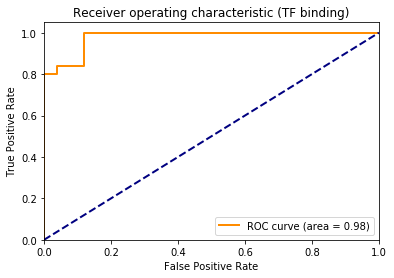

In [40]:
fpr, tpr, thresholds = roc_curve(
    np.concatenate((np.ones(25), np.zeros(25))),
    np_pred_means[:, 0, 0, 1],
)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (TF binding)')
plt.legend(loc="lower right")
plt.show()

array([0.09264916, 0.46551183, 0.3714963 , 0.4830719 , 0.4226134 ,
       0.10788965, 0.05923288, 0.59389925, 0.26882577, 0.13578528,
       0.18255392, 0.07119109, 0.04154459, 0.37574553, 0.26640376,
       0.31071085, 0.31637344, 0.04205887, 0.15907377, 0.21544942,
       0.08286025, 0.25200766, 0.16679156, 0.34304196, 0.40272683,
       0.01217526, 0.00404129, 0.07452332, 0.0195763 , 0.00152926,
       0.00615029, 0.08414429, 0.02212824, 0.01057552, 0.07827973,
       0.00329664, 0.01234252, 0.01264501, 0.00762913, 0.00525373,
       0.02242934, 0.00413483, 0.00476873, 0.00558607, 0.00582548,
       0.00599674, 0.00338491, 0.00835689, 0.00717984, 0.00307272],
      dtype=float32)

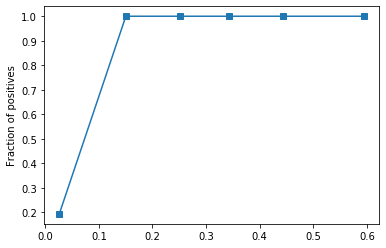

In [42]:
y_test = np.concatenate((np.ones(25), np.zeros(25)))
prob_pos = np_pred_means[:, 0, 0, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test,
    prob_pos,
    n_bins=10
)
clf_score = brier_score_loss(y_test, prob_pos)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
     label="%s (%1.3f)" % ("MC dropout predictive means (TF)", clf_score))
plt.ylabel("Fraction of positives")
# ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
#          histtype="step", lw=2)
prob_pos

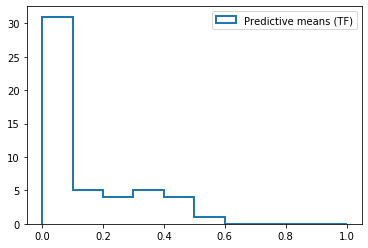

In [43]:
plt.hist(prob_pos, range=(0, 1), bins=10, label="Predictive means (TF)",
          histtype="step", lw=2)
plt.legend()

Text(0, 0.5, 'Fraction of positives')

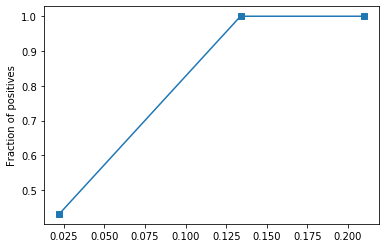

In [44]:
y_test = np.concatenate((np.ones(25), np.zeros(25)))
prob_pos = np_pred_means[:, 0, 0, 0]
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test,
    prob_pos,
    n_bins=10
)
clf_score = brier_score_loss(y_test, prob_pos)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
     label="%s (%1.3f)" % ("MC dropout predictive means (CA)", clf_score))
plt.ylabel("Fraction of positives")

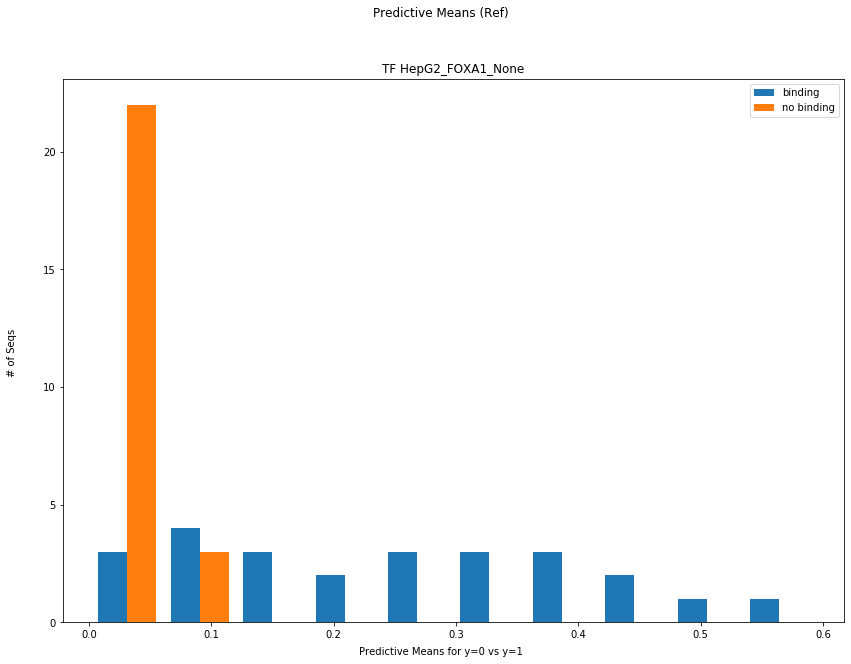

In [45]:
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))
plt.suptitle("Predictive Means (Ref)")

ax1.hist(
    (np_pred_means[:25, 0, 0, 1].reshape(-1),
     np_pred_means[25:, 0, 0, 1].reshape(-1)),
    label=("binding", "no binding"))
ax1.set_title(f"TF {relevant_cols[1][1]}")
ax1.legend()
# ax2.hist(
#     (np_pred_means[:25, 0, 0, 0].reshape(-1),
#      np_pred_means[25:, 0, 0, 0].reshape(-1)),
#     label=("accessible", "not accessible"))
# ax2.set_title(f"DNase {relevant_cols[2][1]}")
# ax2.legend()

fig.text(0.5, 0.08, "Predictive Means for y=0 vs y=1", ha="center")
fig.text(0.07, 0.5, "# of Seqs", va='center', rotation='vertical')

plt.show();

## Basic Visualizations
The next two cells show the distribution of predicted means for the first and second half of the sequences. The first half of the sequences were all randomly drawn from the set of sequences to which FOXA1 binds in HepG2, so most sequences should have binding predicted. The second half of the sequences was randomly drawn from the subset of sequences to which FOXA1 doesn't bind in HepG2 cells, so most sequences shouldn't have binding predicted.

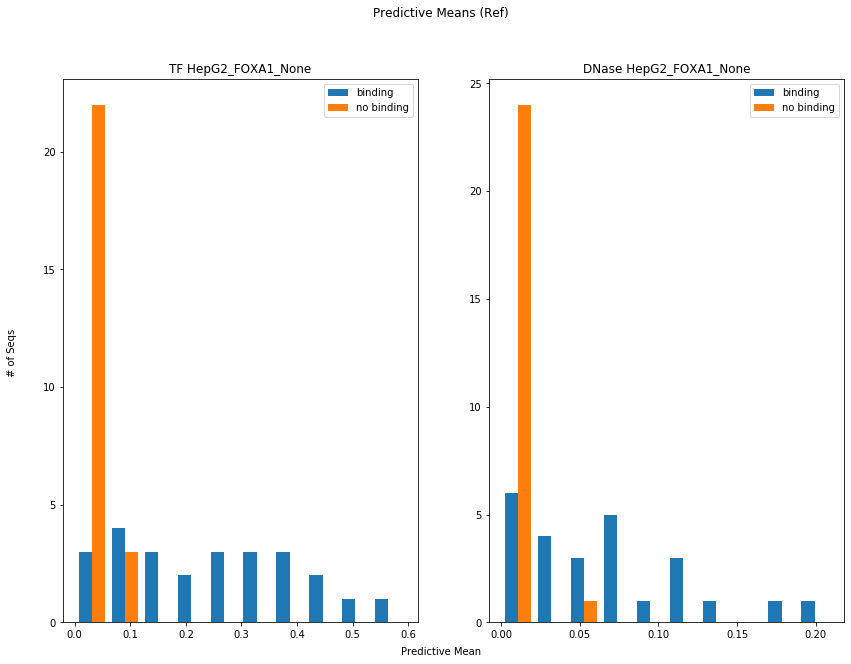

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))
plt.suptitle("Predictive Means (Ref)")

ax1.hist(
    (np_pred_means[:25, 0, 0, 1].reshape(-1),
     np_pred_means[25:, 0, 0, 1].reshape(-1)),
    label=("binding", "no binding"))
ax1.set_title(f"TF {relevant_cols[1][1]}")
ax1.legend()
ax2.hist(
    (np_pred_means[:25, 0, 0, 0].reshape(-1),
     np_pred_means[25:, 0, 0, 0].reshape(-1)),
    label=("binding", "no binding"))
ax2.set_title(f"DNase {relevant_cols[2][1]}")
ax2.legend()

fig.text(0.5, 0.08, "Predictive Mean", ha="center")
fig.text(0.07, 0.5, "# of Seqs", va='center', rotation='vertical')

plt.show();

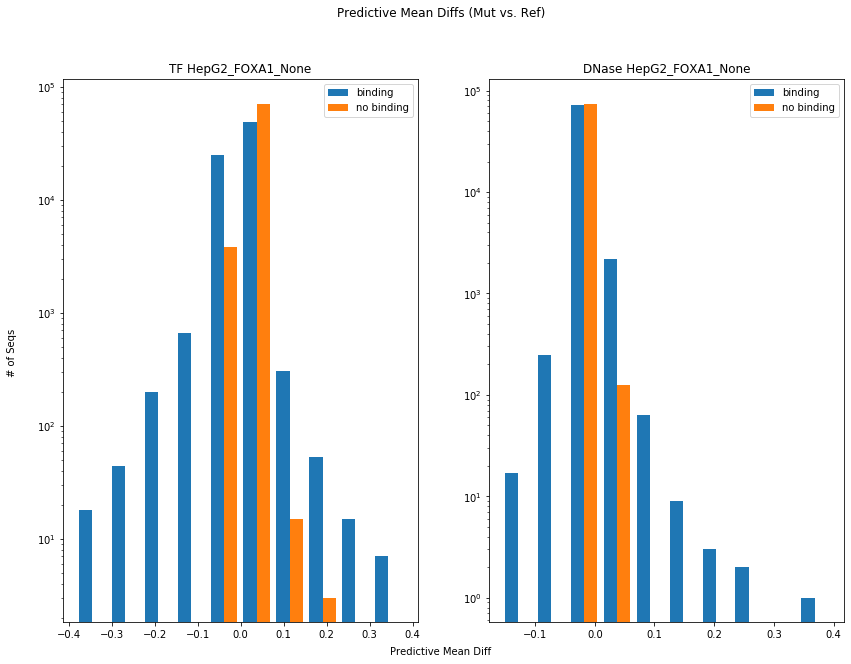

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))
plt.suptitle("Predictive Mean Diffs (Mut vs. Ref)")

ax1.hist(
    (np_pred_mean_diffs[:25, :, 1:, 1].reshape(-1),
     np_pred_mean_diffs[25:, :, 1:, 1].reshape(-1)),
    label=("binding", "no binding"),
    log=True)
ax1.set_title(f"TF {relevant_cols[1][1]}")
ax1.legend()
ax2.hist(
    (np_pred_mean_diffs[:25, :, 1:, 0].reshape(-1),
     np_pred_mean_diffs[25:, :, 1:, 0].reshape(-1)),
    label=("binding", "no binding"),
    log=True)
ax2.set_title(f"DNase {relevant_cols[2][1]}")
ax2.legend()

fig.text(0.5, 0.08, "Predictive Mean Diff", ha="center")
fig.text(0.07, 0.5, "# of Seqs", va='center', rotation='vertical')


plt.show();

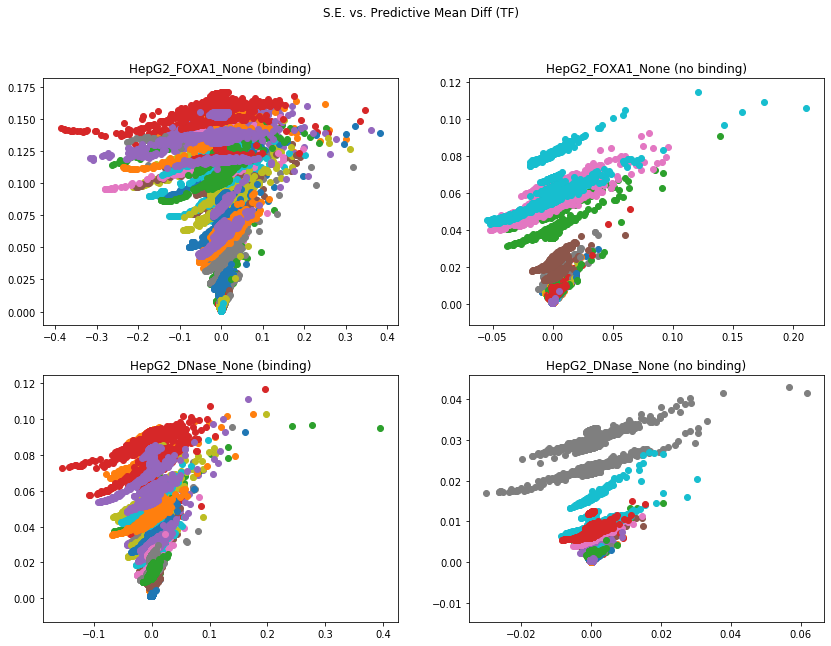

In [48]:
TF_COL = 1
CA_COL = 0

_, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(14, 10))
plt.suptitle("S.E. vs. Predictive Mean Diff (TF)")

for seq in range(n_seqs):
    ax11.scatter(
        np_pred_mean_diffs[seq, :, :, TF_COL].reshape(-1), 
        np_pred_uncertainties[seq, :, :, TF_COL].reshape(-1))
    ax11.set_title(f"{relevant_cols[1][1]} (binding)")

for seq in range(n_seqs // 2, n_seqs):
    ax12.scatter(
        np_pred_mean_diffs[seq, :, :, TF_COL].reshape(-1), 
        np_pred_uncertainties[seq, :, :, TF_COL].reshape(-1))
    ax12.set_title(f"{relevant_cols[1][1]} (no binding)")
    
for seq in range(n_seqs // 2):
    ax21.scatter(
        np_pred_mean_diffs[seq, :, :, CA_COL].reshape(-1), 
        np_pred_uncertainties[seq, :, :, CA_COL].reshape(-1))
    ax21.set_title(f"{relevant_cols[0][1]} (binding)")

for seq in range(n_seqs // 2, n_seqs):
    ax22.scatter(
        np_pred_mean_diffs[seq, :, :, CA_COL].reshape(-1), 
        np_pred_uncertainties[seq, :, :, CA_COL].reshape(-1))
    ax22.set_title(f"{relevant_cols[0][1]} (no binding)")
    
fig.text(0.5, 0.08, "Predictive Mean Diff", ha="center")
fig.text(0.07, 0.5, "Predictive S.E.", va='center', rotation='vertical')

plt.show()

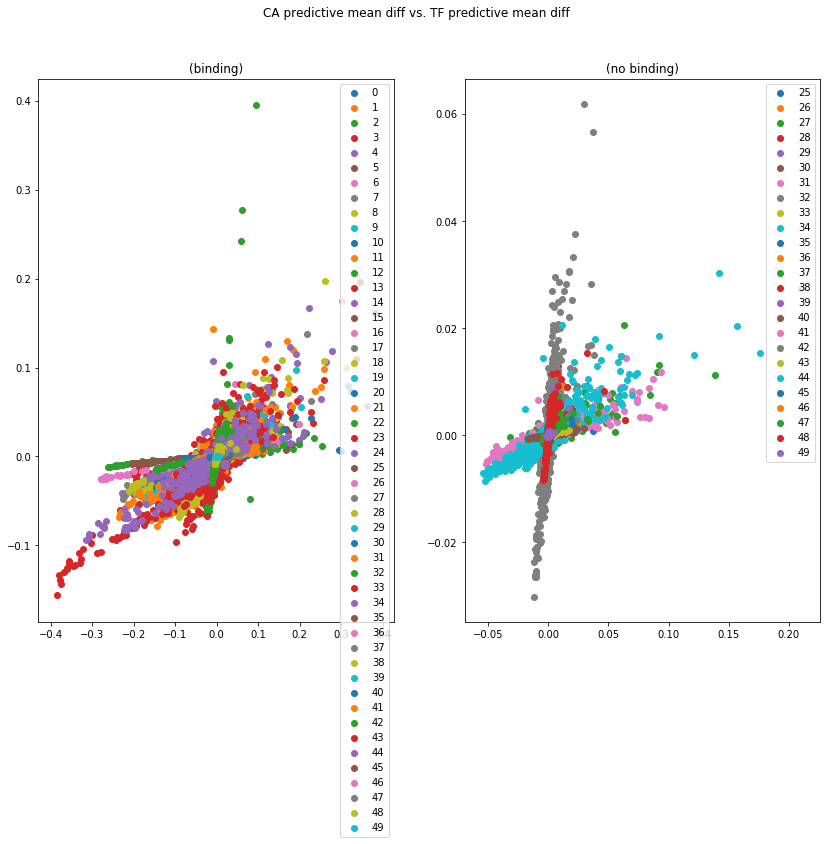

In [49]:
n_binding_seqs = 25
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))
plt.suptitle("CA predictive mean diff vs. TF predictive mean diff")
for seq in range(n_seqs):
    title, ax = ("(binding)", ax1) if seq < n_binding_seqs else ("(no binding)", ax1)
    ax1.scatter(
        np_pred_mean_diffs[seq, :, :, TF_COL].reshape(-1), 
        np_pred_mean_diffs[seq, :, :, CA_COL].reshape(-1), 
        label=seq)
    if seq < n_binding_seqs: ax1.set_title("(binding)")
    ax1.legend()
for seq in range(n_seqs // 2, n_seqs):
    ax2.scatter(
        np_pred_mean_diffs[seq, :, :, TF_COL].reshape(-1), 
        np_pred_mean_diffs[seq, :, :, CA_COL].reshape(-1), 
        label=seq)
    ax2.set_title("(no binding)")
    ax2.legend()
fig.text(0.5, 0.08, "TF Predictive Mean Diff", ha="center")
fig.text(0.07, 0.5, "CA Predictive Mean Diff", va='center', rotation='vertical')

plt.show()

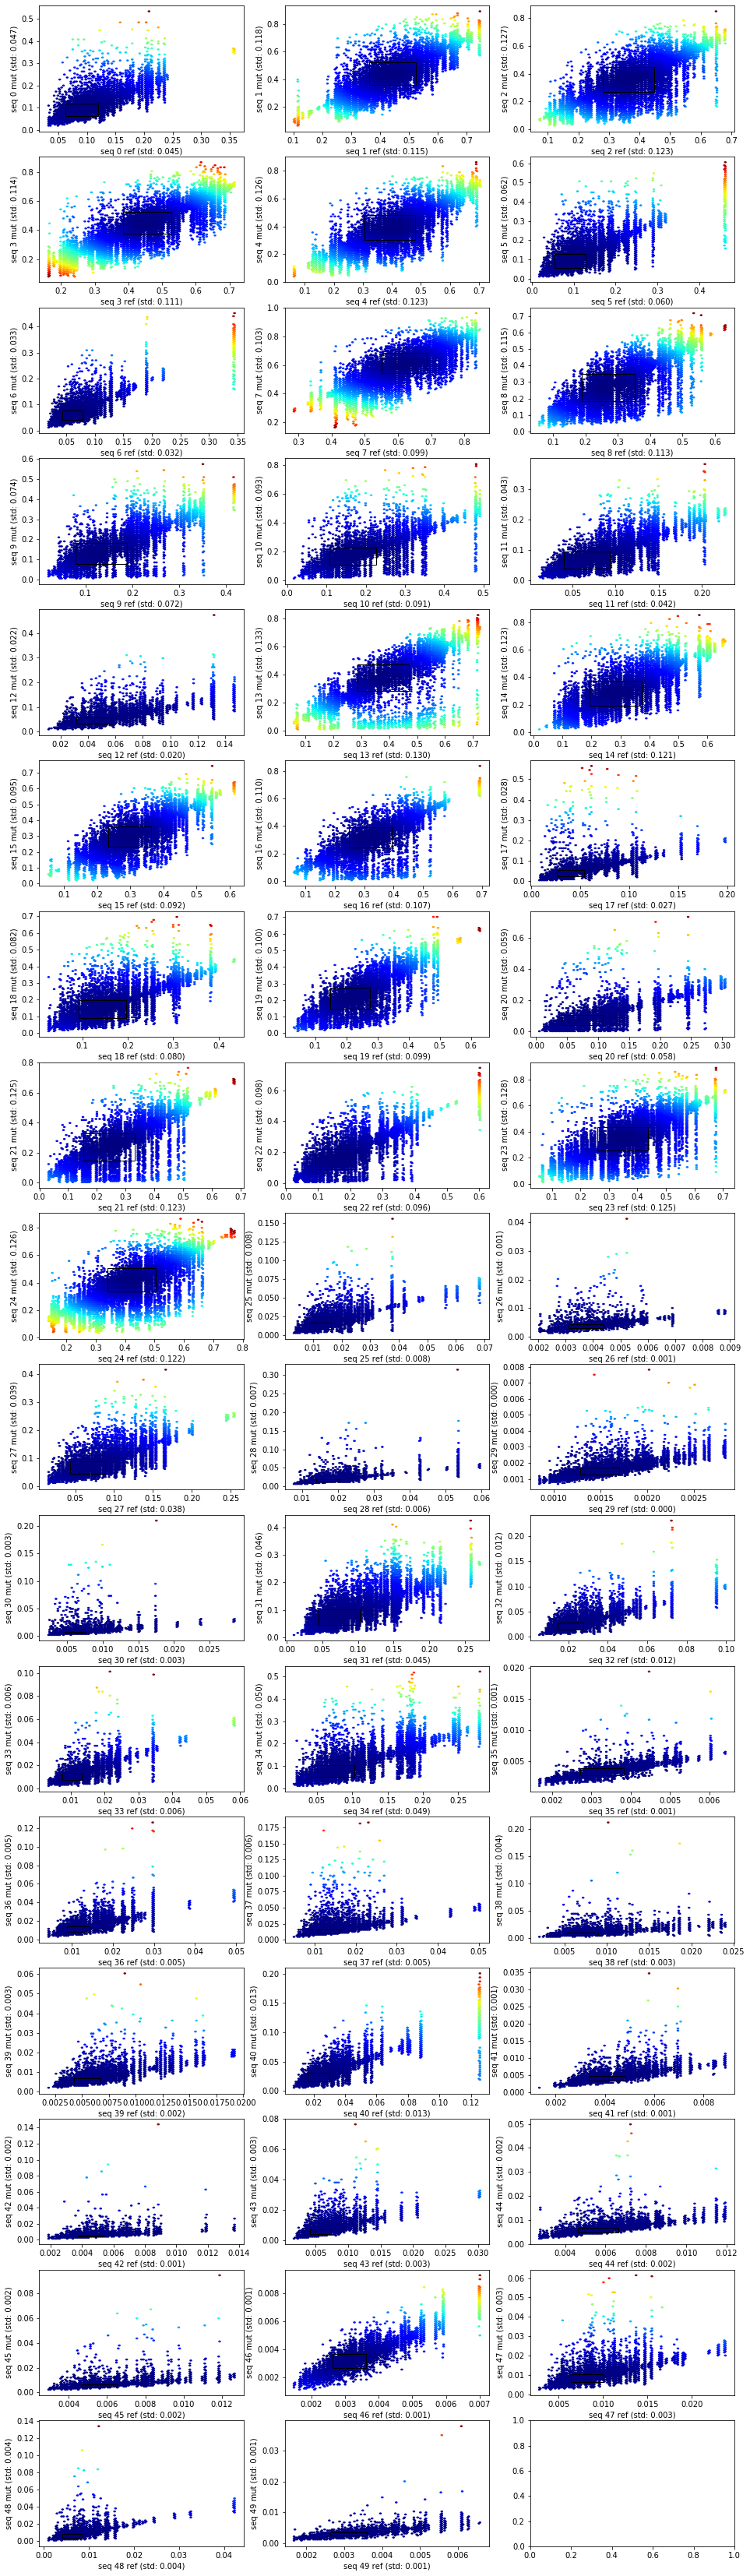

In [50]:
from matplotlib import patches
from matplotlib import cm

cols, margin = 3, 10 # margin determined empirically
fig, axs = plt.subplots(math.ceil(n_seqs / float(cols)), cols, figsize=(16, n_seqs + margin))
# sample_seqs = np.random.random_integers(0, n_seqs, size=4)
# sample_batches = np.random.random_integers(0, n_batches, size=4)
# sample_muts = np.random.random_integers(0, batch_size-1, size=4)
# sample_col = np.random.random_integers(0, len(relevant_cols)-1)

for i in range(n_seqs):
    np_sample_mut_preds = np_preds[:, i, :, 1:, TF_COL]
    np_sample_ref_preds = np.zeros_like(np_sample_mut_preds) + np_preds[:, i, :, :1, TF_COL]
    assert np.allclose(np_sample_ref_preds[:, 0, 0], np_sample_ref_preds[:, 0, 1]) # spot check
    colors = (
        (np_sample_mut_preds.ravel() - np_sample_mut_preds.mean())**2 + 
        (np_sample_ref_preds.ravel() - np_sample_ref_preds.mean())**2
    )
    ax = axs[i // cols, i % cols]
    ax.hexbin(
        np_sample_ref_preds.ravel(), 
        np_sample_mut_preds.ravel(), 
        C=colors,
        cmap=cm.jet,
        bins=None,
    )
    xq1, xq2 = np.quantile(np_sample_ref_preds, (.25, .75))
    yq1, yq2 = np.quantile(np_sample_mut_preds, (.25, .75))
    rect = patches.Rectangle((xq1, yq1), xq2 - xq1, yq2 - yq1, fill=False, edgecolor='black')
    rect = ax.add_patch(rect)
    xlabel = "seq {i} ref (std: {stddev:.3f})".format(i=i, stddev=np.std(np_sample_ref_preds))
    ylabel = "seq {i} mut (std: {stddev:.3f})".format(i=i, stddev=np.std(np_sample_mut_preds))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

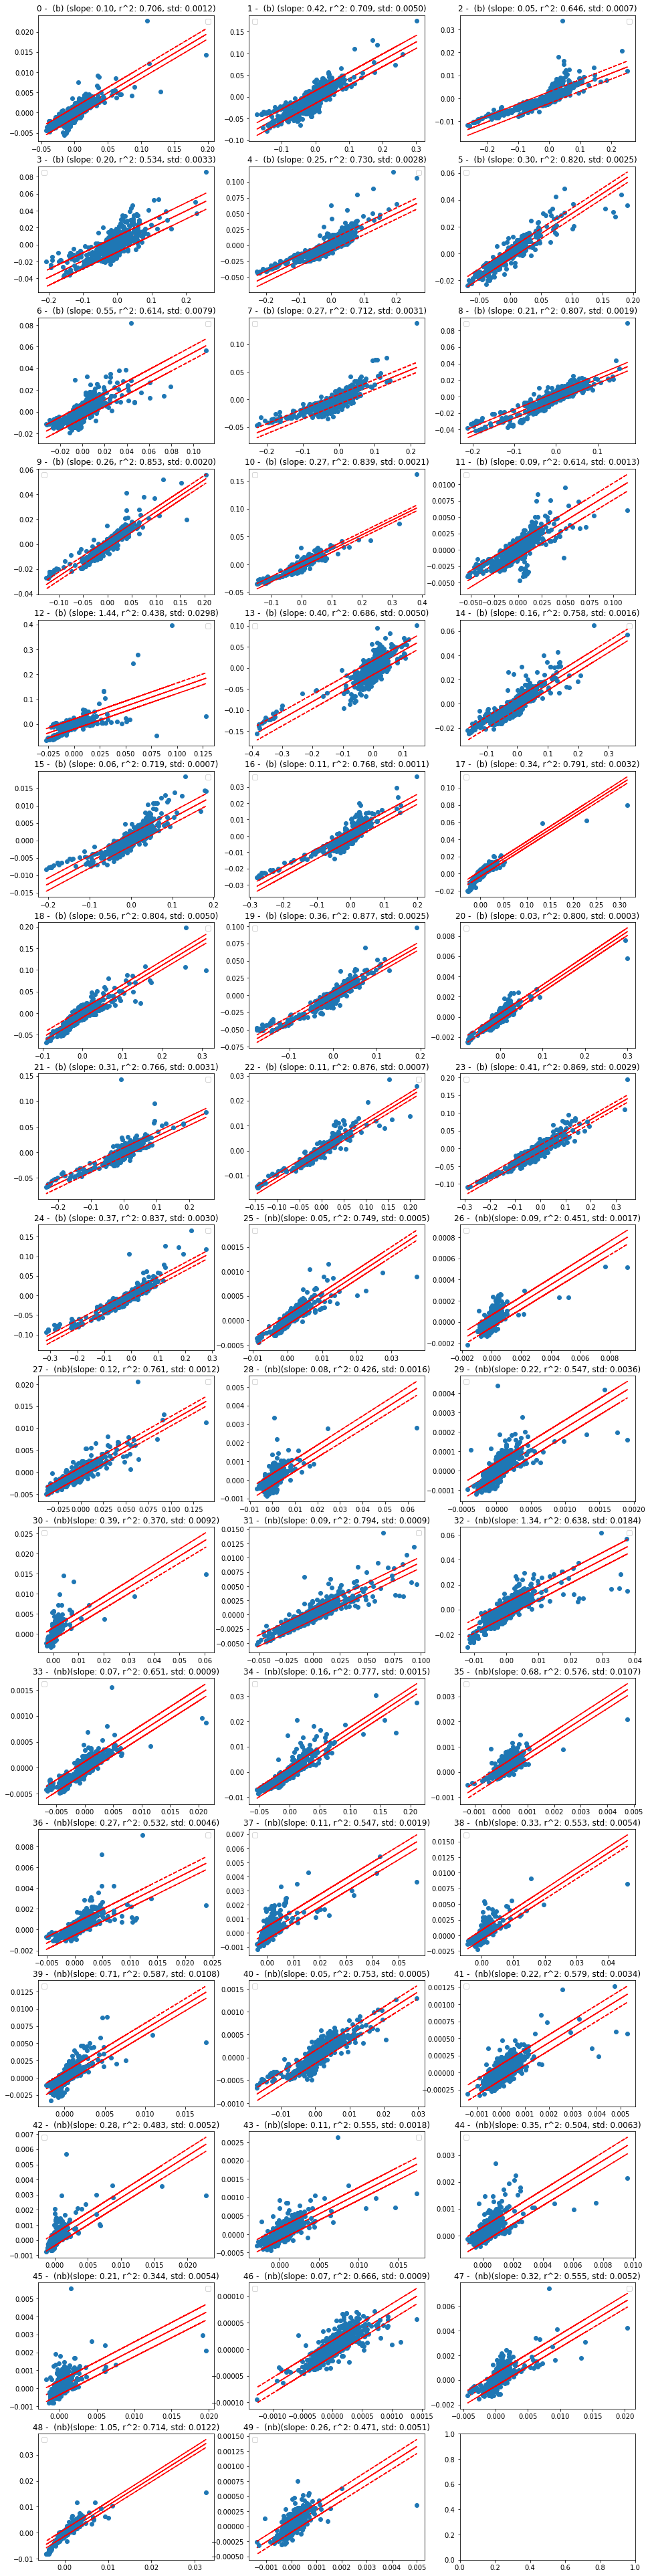

In [89]:
import scipy
from scipy import stats
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std



cols, margin = 3, 20 # margin determined empirically
fig, axs = plt.subplots(math.ceil(n_seqs / float(cols)), cols, figsize=(16, n_seqs + margin))
# plt.suptitle("CA predictive mean diff vs. TF predictive mean diff")
slopes = []
rsquareds = []

for seq in range(n_seqs):
    ax = axs[seq // cols, seq % cols]
    
    x, y = np_pred_mean_diffs[seq, :, :, TF_COL].reshape(-1), np_pred_mean_diffs[seq, :, :, CA_COL].reshape(-1)
    xc = sm.add_constant(x)
    model = sm.OLS(y, xc)
    result = model.fit()
    intercept, slope = result.params
    slopes.append(slope)
    rsquared = result.rsquared
    rsquareds.append(rsquared)
    stderr = result.bse[1]
    
    title = "%d - " % (seq)
    title += " (b) " if seq < n_binding_seqs else " (nb)"
    title += "(slope: %.2f, r^2: %.3f, std: %.4f)" % (slope, rsquared, stderr)
    ax.set_title(title)
    
    line = slope*x+intercept
    prstd, iv_l, iv_u = wls_prediction_std(result)
    ax.plot(x, line, 'r')
    ax.plot(x, y, 'o')
    ax.plot(x, iv_u, 'r--')
    ax.plot(x, iv_l, 'r--')
    legend = ax.legend(loc="best")

    ax1.legend()

    
plt.show()

In [90]:
print(sum(slopes) / len(slopes))
print(sum(rsquareds) / len(rsquareds))

0.3040344448379575
0.663048832721557


In [ ]:

IDX_TO_NT = 'ACGT'

def _convert_to_mutation(pos_nt_pair):
    return "%d%s" % (pos_nt_pair[0], IDX_TO_NT[pos_nt_pair[1]])


TF_COL = 1
CA_COL = 0

def _write_row(writer, seq, batch, i):
    seq_num = seq+1
    mut_num = (batch * (batch_size)) + i
    mut = _convert_to_mutation((mut_num // 3, mut_num % 3))
    x_pred_mean_diff = np_pred_mean_diffs[seq, batch, i, TF_COL]
    x_pred_uncertainty = np_pred_uncertainties[seq, batch, i, TF_COL]
    y_pred_mean_diff = np_pred_mean_diffs[seq, batch, i, CA_COL]
    y_pred_uncertainty = np_pred_uncertainties[seq, batch, i, CA_COL]
    writer.writerow(
        {
            "seq_num": seq_num,
            "mut": mut,
            "X_pred_mean": x_pred_mean_diff,
            "X_pred_var": x_pred_uncertainty,
            "Y_pred_mean": y_pred_mean_diff,
            "Y_pred_var": y_pred_uncertainty,
        }
    )
        

with open("../dat/means_and_uncertainties.csv", 'w', newline="") as out_file:
    fieldnames = [
        "seq_num",
        "mut",
        "X_pred_mean",
        "X_pred_var",
        "Y_pred_mean",
        "Y_pred_var",
    ]
    writer = csv.DictWriter(out_file, delimiter=",", fieldnames=fieldnames)
    writer.writeheader()
    
    for seq in range(n_seqs):
        _write_row(writer, seq, batch, i)
        for batch in range(n_batches):
            for i in range(0, batch_size-1):
                _write_row(writer, seq, batch, i)
 


In [ ]:
# zeros = np.zeros((2, 3))
# def sanitize_scores(scores):
#     orig_shape = scores.shape
#     sanitized_scores = np.ndarray((*orig_shape, 2, 3), dtype=scores.dtype)
#     flattened_scores = scores.reshape(-1)
    
#     for i, score in enumerate(flattened_scores):
#         idx = np.unravel_index(i, orig_shape)
#         if score is None: sanitized_scores[idx] = zeros
#         else: sanitized_scores[idx] = np.array(score)
#     return sanitized_scores

# sanitized_scores = sanitize_scores(np.squeeze(ism_score))
# ctcf_original_preds = sanitized_scores[:, :, :, 0, 1]
# ctcf_pred_diffs = sanitized_scores[:, :, :, 1, 1]
# dnase_original_preds = sanitized_scores[:, :, :, 0, 0]
# dnase_pred_diff = sanitized_scores[:, :, :, 1, 0]

In [ ]:

log_uniform_prop = math.log(.05/(1-.05))
def compute_normalized_prob(prob, train_prob):
    denom = 1+np.exp(-(np.log(prob/(1-prob))+log_uniform_prop-np.log(train_prob/(1-train_prob))))
    return 1 / denom

# Ratios and normalization formula drawn from here: http://deepsea.princeton.edu/media/help/posproportion.txt
# tf_compute_normalized_prob = lambda prob: compute_normalized_prob(prob, .020029)
# ENCODE	A549	DNase	None	0.048136
# chrom_acc_normalized_prob = lambda prob: compute_normalized_prob(prob, 0.048136)